In [1]:
!pip install albumentations > /dev/null
!pip install -U segmentation-models
#!pip install -U efficientnet
import numpy as np
import pandas as pd
import gc
import keras

import itertools

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute, GlobalMaxPooling2D
from keras.optimizers import SGD,Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import NASNetMobile,MobileNetV2,densenet,resnet50,xception,VGG16

from keras_applications.resnext import ResNeXt50

import glob
import shutil
import os
import random
from PIL import Image
import cv2
from random import shuffle
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
!pip install image-classifiers==1.0.0
from classification_models.keras import Classifiers
%matplotlib inline

Using TensorFlow backend.


## Creating Dataframe containing file_path, mask percentage and corresponding label(pneumothorax or no pneumothorax)

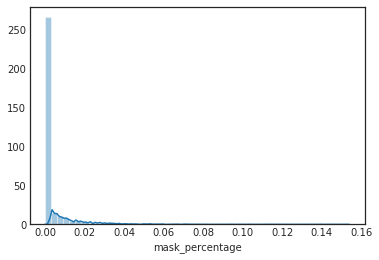

In [2]:
all_mask_fn = glob.glob('/kaggle/input/siimacr-pneumothorax-segmentation-data-512/masks/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(512*512*255) #255 is bcz img range is 255
    
mask_df.reset_index(inplace=True)
sns.distplot(mask_df.mask_percentage)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1

In [3]:
mask_df

,file_names,mask_percentage,labels
0,/kaggle/input/siimacr-pneumothorax-segmentatio...,0.000000,0
1,/kaggle/input/siimacr-pneumothorax-segmentatio...,0.000000,0
2,/kaggle/input/siimacr-pneumothorax-segmentatio...,0.000000,0
3,/kaggle/input/siimacr-pneumothorax-segmentatio...,0.000000,0
4,/kaggle/input/siimacr-pneumothorax-segmentatio...,0.000000,0
...,...,...,...
12042,/kaggle/input/siimacr-pneumothorax-segmentatio...,0.000000,0
12043,/kaggle/input/siimacr-pneumothorax-segmentatio...,0.010412,1
12044,/kaggle/input/siimacr-pneumothorax-segmentatio...,0.039389,1
12045,/kaggle/input/siimacr-pneumothorax-segmentatio...,0.000000,0


## Train-test splitting of 85%-15%

In [4]:
train_df,val_df = train_test_split(mask_df,test_size = 0.15,stratify = mask_df.labels,random_state = 100)

In [5]:
print('No. of train files:', len(train_df))
print('No. of val files:', len(val_df))

No. of train files: 10239
No. of val files: 1808


In [6]:
train_filepath = train_df['file_names'].tolist()
val_filepath = val_df['file_names'].tolist()
train_im_path = 'train'
train_mask_path = 'masks'
img_size = 512

## Adding Augmentations

In [7]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)
train_augment = Compose([
    HorizontalFlip(p = 0.5),
    ShiftScaleRotate(p = 0.5),
    CLAHE(clip_limit = 2.0,tile_grid_size = (32,32)),
   # ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03,p = 0.5),
    RandomGamma(p = 0.5),
    ToFloat()
])

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    
    RandomSizedCrop(min_max_height=(176, 256), height=512, width=512,p=0.25),
    ToFloat()
],p=1)



## DataGenerator Class

In [8]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self,filepath = train_filepath,train_im_path = train_im_path,train_mask_path = train_mask_path,
                 augmentations = None,img_size = img_size,batch_size = 64,nchannels = 3,shuffle = True):
        
        self.train_im_paths = list(filepath)
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.nchannels = nchannels
        self.shuffle = shuffle
        self.augmentations = augmentations
        self.on_epoch_end()
    
    def __len__(self):
        
        return int(np.ceil(len(self.train_im_paths)/ self.batch_size))
    
    def __getitem__(self,index):
        
        indexes = self.indexes[index * self.batch_size : min((index + 1) * self.batch_size, len(self.train_im_paths))]
        list_im_ids = [self.train_im_paths[i] for i in indexes]
        X,y = self.data_generation(list_im_ids)
        
        if(self.augmentations is None):
            return np.array(X,dtype = 'float32'),y
        
        im = []
        for x in X:
            augmented = self.augmentations(image = x)
            im.append(augmented['image'])
        return np.array(im,dtype = 'float32'),y
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.train_im_paths))
        if(self.shuffle):
            np.random.shuffle(self.indexes)
    
    def data_generation(self,list_im_ids):
        
        X = np.empty((len(list_im_ids),self.img_size,self.img_size,self.nchannels))
        y = np.empty((len(list_im_ids),))
        for i,mask_path in enumerate(list_im_ids):
            
            img_path = mask_path.replace(self.train_mask_path,self.train_im_path)
            
            img = cv2.imread(img_path)

            if(len(img.shape) == 2):
                img = np.repeat(img[...,np.newaxis],3,2)
            
            X[i,] = cv2.resize(img,(self.img_size,self.img_size))
            y[i] = id_label_map[mask_path]

        return np.uint8(X),y

def chunker(sequence,size):
    return (sequence[pos : pos + size] for pos in range(0,len(sequence),size))

id_label_map = {i : j for i,j in zip(mask_df.file_names.values,mask_df.labels.values)}

def data_gen(list_files,id_label_map,batch_size,aug_func):
    aug = aug_func
    while True:
        shuffle(list_files)
        for block in chunker(list_files,batch_size):
            x = [aug(image = cv2.imread(addr.replace('masks','train')))['image'] for addr in block]
            y = [id_label_map[addr] for addr in block]
            yield np.array(x),np.array(y)

## Testing the Generator

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

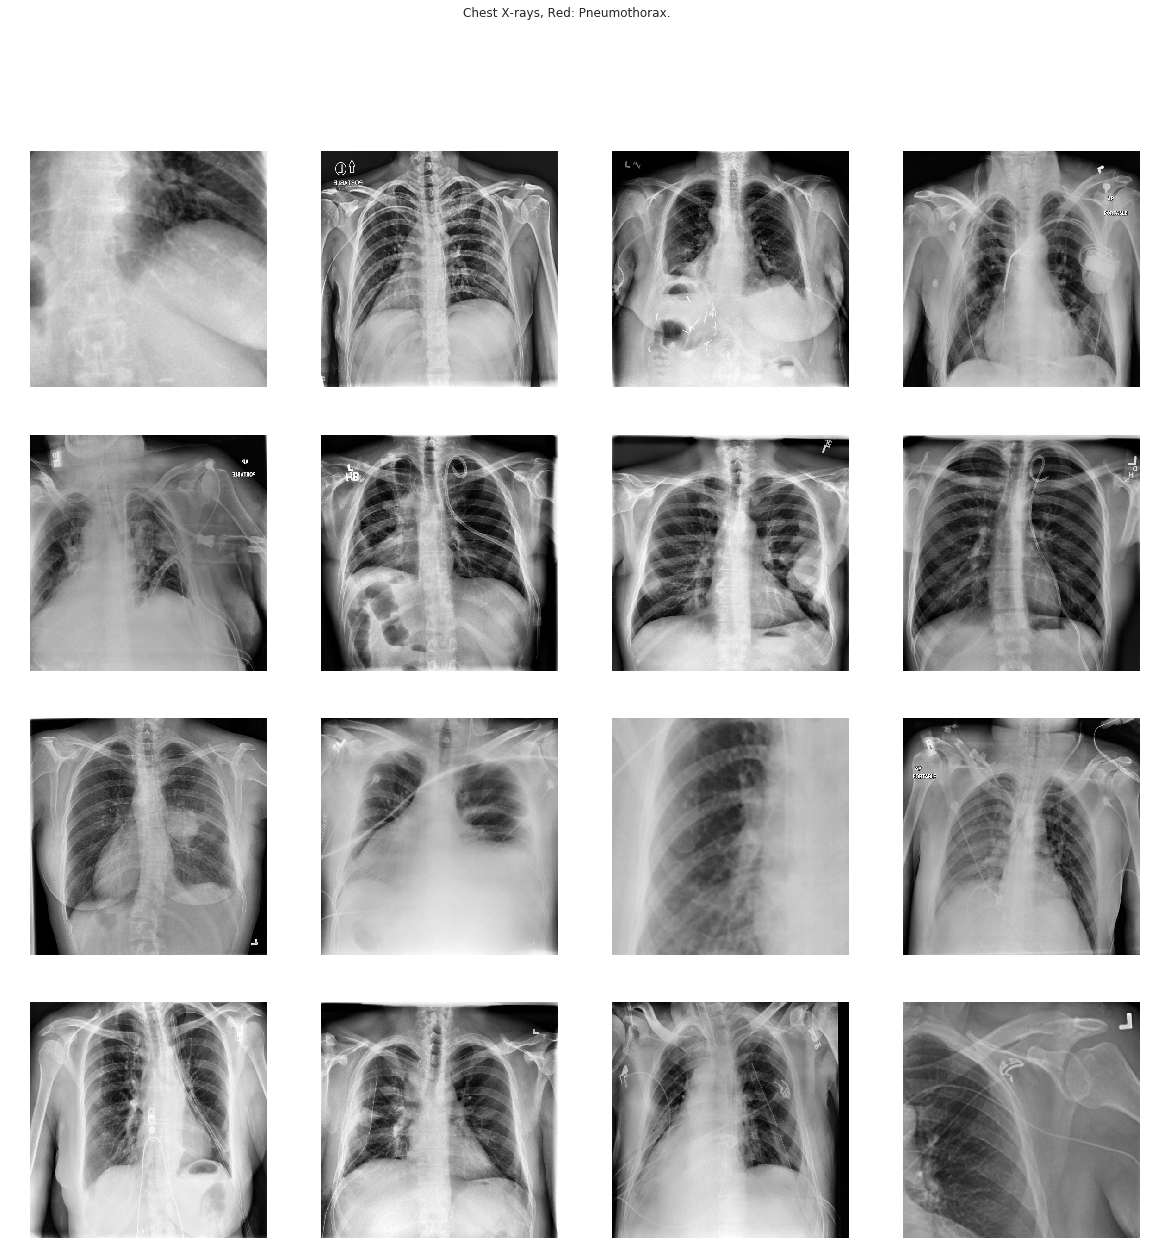

In [9]:
a = DataGenerator(batch_size=16,shuffle=False,augmentations=AUGMENTATIONS_TRAIN)
images,masks = a.__getitem__(0)
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    #ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

## ResNet50 model code

In [10]:

def resnet50_model(input_shape):
    resnet50, preprocess_input = Classifiers.get('resnet50')
    base_model = resnet50((512, 512, 3), weights='imagenet', include_top = False)
    x = base_model.output

    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    #out3 = Flatten()(x)
    out = concatenate([out1,out2])
    out = BatchNormalization(epsilon = 1e-5)(out)
    out = Dropout(0.4)(out)
    fc = Dense(256,activation = 'relu')(out)
    fc = BatchNormalization(epsilon = 1e-5)(fc)
    fc = Dropout(0.3)(fc)
    X = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros')(fc)
    model =  Model(inputs=base_model.input, outputs=X)
    #model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001), loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])
    return model

In [11]:
model =resnet50_model((512,512,3))

94593024/94592056 [==============================] - 2s 0us/step


## Stochatic Weight Averaging Class

In [12]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')


## Cosine Annealing Learning Rate Class

In [13]:
class SnapshotCallbackBuilder:
    
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.01):
      
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./best_model.h5",monitor='val_loss', 
                                   mode = 'min', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)



## Compile the model

In [14]:
#model.compile(loss = sm.losses.bce_jaccard_loss,optimizer = SGD(learning_rate = 0.0001, momentum=0.0, nesterov=False),metrics = [sm.metrics.iou_score])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

## Train Code

In [15]:
train_filepath = train_df['file_names'].tolist()
val_filepath = val_df['file_names'].tolist()
train_im_path = 'train'
train_mask_path = 'masks'
epochs = 50
snapshot = SnapshotCallbackBuilder(nb_epochs = epochs,nb_snapshots = 1, init_lr = 1e-3)
swa = SWA('./swa_weights.hdf5',epochs - 4)
batch_size = 16
train_generator = data_gen(train_filepath,id_label_map,batch_size,AUGMENTATIONS_TRAIN)
val_generator = data_gen(val_filepath,id_label_map,batch_size,AUGMENTATIONS_TRAIN)
history = model.fit_generator(train_generator,validation_data = val_generator,epochs = epochs,callbacks = snapshot.get_callbacks(),
                              steps_per_epoch = (len(train_filepath) // batch_size) + 1,
                              validation_steps = (len(val_filepath) // batch_size) + 1,
                              )

Stochastic weight averaging selected for last 4 epochs.
Epoch 1/50
640/640 [==============================] - 610s 954ms/step - loss: 0.5876 - acc: 0.7393 - val_loss: 0.6475 - val_acc: 0.7780

Epoch 00001: val_loss improved from inf to 0.64752, saving model to ./best_model.h5
Epoch 2/50
640/640 [==============================] - 571s 892ms/step - loss: 0.5087 - acc: 0.7803 - val_loss: 0.4605 - val_acc: 0.7812

Epoch 00002: val_loss improved from 0.64752 to 0.46048, saving model to ./best_model.h5
Epoch 3/50
640/640 [==============================] - 586s 916ms/step - loss: 0.4862 - acc: 0.7860 - val_loss: 0.5086 - val_acc: 0.7714

Epoch 00003: val_loss did not improve from 0.46048
Epoch 4/50
640/640 [==============================] - 574s 896ms/step - loss: 0.4691 - acc: 0.7924 - val_loss: 0.2173 - val_acc: 0.7906

Epoch 00004: val_loss improved from 0.46048 to 0.21728, saving model to ./best_model.h5
Epoch 5/50
640/640 [==============================] - 571s 892ms/step - loss: 0.4652 

## Plotting Model Accuracy against number of epochs

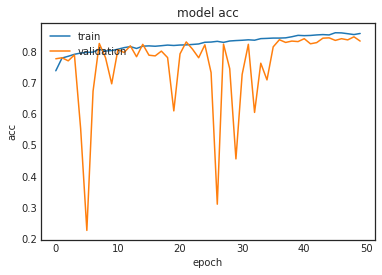

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.savefig('loss_performance.png')
plt.clf()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='valid')
plt.title("model acc")
plt.ylabel("acc")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.savefig('acc_performance.png')